<a href="https://colab.research.google.com/github/nicholasrichers/Desafio-Cola-Cola-Sofazao/blob/master/DesafioPeta_Sofazao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Resumo: Colocar aqui um resumo da análise até o momento...
GIT

https://github.com/nicholasrichers/Desafio-Cola-Cola-Sofazao

# Setup

## Importando Bibliotecas

> Instalando Pacotes

In [0]:
!pip install pendulum
!pip install --upgrade statsmodels

     |████████████████████████████████| 143kB 2.9MB/s 
     |████████████████████████████████| 491kB 9.2MB/s 
     |████████████████████████████████| 8.7MB 2.9MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


> Pacote Datetime usado nesse estudo

In [0]:
import os, random, re, sys, time, warnings
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot
import seaborn as sns
from itertools import combinations
from scipy.stats import pearsonr

pd.set_option('display.max_rows', 250)
pd.options.display.float_format = '{:,.2f}'.format
%matplotlib inline

> Bibliotecas Privadas

In [0]:
!git clone https://github.com/nicholasrichers/Desafio-Cola-Cola-Sofazao.git

Cloning into 'Desafio-Cola-Cola-Sofazao'...
remote: Enumerating objects: 188, done.
remote: Counting objects: 100% (188/188), done.
remote: Compressing objects: 100% (129/129), done.
remote: Total 188 (delta 96), reused 145 (delta 58), pack-reused 0
Receiving objects: 100% (188/188), 224.78 KiB | 11.83 MiB/s, done.
Resolving deltas: 100% (96/96), done.


> (APENAS GOOGLE COLAB) Chamamos a função load_library como no exemplo abaixo para importar as bibliotecas privadas.

```
load_library('lib_name', 'libraries/filename.py')

import lib_name
ou
from lib_name import function_name
```



In [0]:
from importlib.machinery import SourceFileLoader
def load_library(NAME_LIB, FILE_PATH):
  FILE_PATH = '/content/Desafio-Cola-Cola-Sofazao/Datathon_Peta/' + FILE_PATH
  somemodule = SourceFileLoader(NAME_LIB, FILE_PATH).load_module()

In [0]:
load_library('adjust_datetime', 'libraries/adjust_datetime.py')
load_library('adjust_datatype', 'libraries/adjust_datatype.py')
load_library('plot_libraries', 'libraries/plot_libraries.py')
load_library('holidays', 'libraries/holidays.py')
load_library('stats', 'libraries/stats.py')

In [0]:
load_library('pre_processing_vendas', 'routines/pre_processing_vendas.py')
load_library('pre_processing_macro', 'routines/pre_processing_macro.py')
load_library('merge_datasets', 'routines/merge_datasets.py')
load_library('pre_processing', 'routines/pre_processing.py')



---



---



## Upload dataset

> Subimos os arquivos para um repositorio público no [github](https://github.com/nicholasrichers/Desafio-Cola-Cola-Sofazao/tree/master/Datathon%20Peta) para garantir que pode ser lido de qualquer máquina.



In [0]:
REPO_URL = 'https://raw.githubusercontent.com/nicholasrichers/Desafio-Cola-Cola-Sofazao/master/Datathon_Peta/datasets/'

df_vendas = pd.read_csv(REPO_URL + 'Alasca_nordeste.csv', sep=';')
df_macro =  pd.read_csv(REPO_URL + 'macroeconomia.csv', sep=';')
X_train =   pd.read_csv(REPO_URL + 'trainDF.csv', sep=',', infer_datetime_format=True, parse_dates=['Datetime'], index_col=['Datetime'])
X_test =    pd.read_csv(REPO_URL + 'testDF.csv',  sep=',', infer_datetime_format=True, parse_dates=['Datetime'], index_col=['Datetime'])

vendas_raw = df_vendas.copy() #nao mexer
macro_raw = df_macro.copy() #nao mexer

print(f'Alasca Shape: {df_vendas.shape} || Macro Shape: {df_macro.shape}') 

Alasca Shape: (242, 14) || Macro Shape: (59, 8)




---



---



# Pré Processamento

## Dataset vendas

*Nessa seçao vamos fazer um primeiro contato com cada coluna, Para identificar potenciais erros e necessidade de colunas adicionais.*

### Coluna: **Data**

> Observações:

1.     *(17/Jan)* - Data exata no calendario gregoriano
2.     *S* - Todas as datas selecionadas caem num sábado
3.     *03/01/15* - A primeira informação '03' remete a 3ª semana do mes '01' seguindo o calendário 4-4-5

In [0]:
df_vendas['Data'].iloc[2]

'(17/jan) S 03/01/15'



---



---



### Colunas: **Total, SM, Route e Indiretos**

> *Observações:*

1. As 3 colunas são do tipo string, vamos convertê-las para numérico
2. *SM* = Supermercado, Route = Bares e lanchonetes, Indiretos = Depositos e Distribuidoras. 
3. Criaremos um canal "Outros" para a soma dos canais dar igual ao Total.

In [0]:
df_vendas.iloc[:, 1:5].dtypes

Total        object
SM           object
ROUTE        object
INDIRETOS    object
dtype: object

> Como o google colab nao possui o tipo 'pt_BR.utf8', teremos que alterar o formato dos numeros manualmente via regex

In [0]:
!locale -a

C
C.UTF-8
en_US.utf8
POSIX


In [0]:
#private library
from adjust_datatype import PT_BR_string_to_numeric

In [0]:
for col in df_vendas.columns[1:5]: 
  df_vendas[col] = PT_BR_string_to_numeric(df_vendas, col)

> Criando o quarto canal de vendas "Outros". Vemos que esse canal representa geralmente um terço do volume de vendas que não consta do banco de dados.

In [0]:
df_vendas['OUTROS'] = df_vendas['Total'] - df_vendas[df_vendas.columns[2:5]].sum(axis=1)

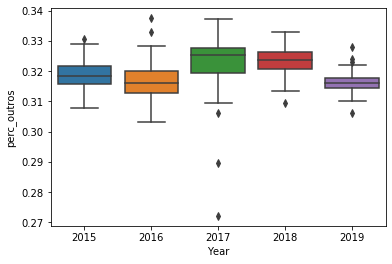

In [0]:
df_vendas['perc_outros'] = df_vendas['OUTROS'] / df_vendas['Total']
sns.boxplot(y='perc_outros', x='Year', data=df_vendas)



---



---



### Colunas **Week_445,	Month_445,	Day_gregoriano,	Month_gregoriano,	Year,	Data.1**

*Observações:*


1.   Em algumas linhas o "Month_445" está diferente do "Month_gregoriano"
2.   Existem Alguns erros similares para a coluna "week_445"
3.   Como já existe uma coluna chamada "Data", o pandas renomeuou para "Data.1".





Percebemos esse descasamento entre as colunas "Month_445" e "Month_gregoriano", sempre na ultima semana de alguns meses, devido ao formato do calendário 445, essas diferenças podem atrapalhar na hora de plotar gráficos, então criaremos colunas provisórias para esse fim. 

In [0]:
df_vendas[df_vendas.Month_445 != df_vendas.Month_gregoriano].iloc[:,[0,6,8]].head(6)

,Data,Month_445,Month_gregoriano
4,(31/jan) S 01/02/15,2,1
8,(28/fev) S 01/03/15,3,2
21,(30/mai) S 01/06/15,6,5
34,(29/ago) S 01/09/15,9,8
43,(31/out) S 01/11/15,11,10
47,(28/nov) S 01/12/15,12,11


Vamos também renomear a coluna Data.1 para Datetime, e trocar o tipo para datetime.

In [0]:
df_vendas.rename(columns={'Data.1':'Datetime'}, inplace=True)
df_vendas['Datetime'] = pd.to_datetime(df_vendas['Datetime'], format='%d/%m/%Y')

Criamos uma coluna similar a "week_445" chamada "week_month", a para evitar inconsistências.

In [0]:
from adjust_datetime import week_of_month

In [0]:
df_vendas['Week_Month'] = df_vendas['Datetime'].map(week_of_month)

Aproveitamos para criar uma coluna "week_year", que será util mais a frente.

Obs: A função dt.weekofyear do pandas  retorna 52 para o dia 1-Jan, seguindo o [padrão ISO](https://stackoverflow.com/questions/44372048/python-pandas-timestamp-week-returns-52-for-first-day-of-year/44372130), contudo essa diferença causou alguns problemas na análise na seção subsequente, então optamos por inserir a coluna "week_year" manualmente.

In [0]:
years = math.ceil(df_vendas.shape[0]/52)
df_vendas['Week_Year'] = ([i for i in range(1,53)]*years)[0:df_vendas.shape[0]]



---



---



### Colunas **holidays,	weekend,	work_day**

*Observações:*


1.  A soma das 3 colunas deveria dar 7
2.  Maior parte das colunas dão {h: 0, w:2, wd: 5} como esperado.
3.  Sempre há diferenças na primeira e segunda semana de cada ano, e em algumas com feriado
4. Isso acontece porque alguns intervalos não tem uma diferença de 7 dias como se supunha.


In [0]:
df_vendas[(df_vendas.holidays + df_vendas.weekend + df_vendas.work_day) != 7].iloc[:, 9:14]

,Year,Datetime,holidays,weekend,work_day
0,2015,2015-01-01,1,0,0
1,2015,2015-01-10,0,3,6
46,2015,2015-11-21,1,2,5
52,2016,2016-01-01,1,1,4
53,2016,2016-01-09,0,3,5
70,2016,2016-05-07,1,2,5
104,2017,2017-01-01,2,3,5
105,2017,2017-01-07,0,1,5
156,2018,2018-01-01,2,3,4
157,2018,2018-01-06,0,1,4




---



---



## Dataset Macro

*Primeira análise das colunas do dataset MACRO*

Dicionário Colunas:
1. *Data*: Mensal entre Jan-2015 e Nov-2019 (vendas => Ago-2019)
2. *Temperatura*: Média mensal
3. *Ocupação*: Taxa inversa ao desemprego, mas inclui economia informal
4. *Ajuste_ipca*: Calcula a variação percentual entre cada mês da tabela q vc vai ter o IPCA daquele mês
5. *PMC*: Pesquisa Mensal do Comércio (IBGE)
6. *Massa.Renda*: (pop * renda_ppc)
7. *Renda*: Renda Per Capita NE (IBGE)
8. *Desemprego*: Taxa(%) desemprego NE

> Agora vamos analisar o tipo das colunas do **Dataset Macro**, e fazer os ajutes necessários

In [0]:
df_macro.dtypes

Data           object
temperatura    object
Ocupacao       object
Ajuste_ipca    object
PMC            object
Massa.Renda    object
Renda          object
Desemprego     object
dtype: object

> Vamos passar a coluna **Data** para o tipo datetime.

In [0]:
df_macro['Data'] = pd.to_datetime(df_macro['Data'], format='%d/%m/%Y')

> Vamos ajustar os valores do tipo string para numérico, como feito na seção anterior, para todas as outras colunas

In [0]:
for col in df_macro.columns[1::]: 
  df_macro[col] = PT_BR_string_to_numeric(df_macro, col)

> Usamos o método describe em busca de potenciais valores nulos e outliers para esse dataset, aparentemente o valor fora da curva se encontra na coluna **Massa.Renda** que possui um valor mínimo muito abaixo do 1º Quartil, indicando um possível **outlier**.

In [0]:
df_macro.describe()

,temperatura,Ocupacao,Ajuste_ipca,PMC,Massa.Renda,Renda,Desemprego
count,59.00,59.00,59.00,59.00,59.00,59.00,59.00
mean,27.03,"23,383.11",300.24,87.50,"4,229,405.91","1,572.52",13.32
std,0.82,605.27,19.77,8.63,"1,571,830.71",38.98,1.90
min,25.06,"22,420.47",256.57,75.31,"1,615.21","1,500.53",9.28
25%,26.29,"22,954.20",288.70,82.65,"4,611,945.20","1,541.01",12.70
50%,27.29,"23,363.04",302.34,85.25,"4,794,792.25","1,576.33",13.90
75%,27.66,"23,688.78",316.55,89.53,"4,952,818.40","1,601.76",14.44
max,28.31,"24,420.64",329.48,115.78,"5,047,993.34","1,619.34",15.82


> Olhando esse valor mais de perto vemos claramente que esse valor (Massa.Renda = 1615.21) foi inserido de forma errada, replicando o valor da coluna subsequente, vamos tratar esse e demais erros na próxima seção.

Obs: Até o momento usamos apenas os dados macro até Ago-2019, periodo do dataset vendas, logo esse registo com erro foi cortado

In [0]:
df_macro.tail(10)

,Data,temperatura,Ocupacao,Ajuste_ipca,PMC,Massa.Renda,Renda,Desemprego
49,2019-02-01,27.48,"22,966.75",320.79,79.01,"1,615.21","1,615.21",15.20
50,2019-03-01,27.51,"23,089.94",323.19,82.65,"1,619.34","1,619.34",14.97
51,2019-04-01,27.19,"23,321.52",325.03,81.92,"4,830,741.06","1,615.21",13.98
52,2019-05-01,26.54,"23,363.04",325.46,82.65,"4,830,713.16","1,615.21",14.07
53,2019-06-01,25.96,"23,352.33",325.51,81.92,"4,830,713.16","1,615.21",14.24
54,2019-07-01,25.55,"23,833.07",326.33,85.37,"4,957,543.20","1,615.21",13.80
55,2019-08-01,25.95,"23,769.46",326.74,79.01,"4,830,713.16","1,615.21",13.90
56,2019-09-01,26.64,"23,680.63",327.62,85.37,"4,957,543.20","1,619.34",13.98
57,2019-10-01,27.44,"23,694.88",328.55,110.62,"1,615.21","1,615.21",13.99
58,2019-11-01,27.83,"23,682.69",329.48,85.37,"4,957,543.20","1,615.21",13.97




---

---


## Selecão de variáveis

### Dataset Vendas

> **Features** altamente **correlacionadas** acabam perdendo perdendo relevância na tomada de decisão do modelo, **dificultando a interpretabilidade**. Para calcular a correlação entre as colunas vamos usar o coeficiente de correlação de **Pearson R**, para todas as possíveis combinações de colunas.

In [0]:
num_feat = df_vendas.select_dtypes('number').columns.values
comb_num_feat = np.array(list(combinations(num_feat, 2)))
corr_num_feat = np.array([])

for comb in comb_num_feat:
  corr = pearsonr(df_vendas[comb[0]], df_vendas[comb[1]])[0]
  corr_num_feat = np.append(corr_num_feat, corr)

> Agora vamos analisar os pares de colunas com **correlação acima de |0.9|**

*Observações:*


1.  *Total*:  Possui alta correlação com todos os outros canais como esperado
2.  *Outros*: Também possui alta correlação com os outros canais por ser uma coluna derivada das mesmas (podendo ser descartada futuramente).
3.  *O par ["Month_445", "Month_gregoriano"]*: também está altamente correlacionado por obvio, não fazendo sentido manter ambas, logo iremos **descartar** a coluna **"Month_445"** porque foram encontradas algumas inconsistências nessa coluna durante a fase de pré-processamento

In [0]:
high_corr_num = comb_num_feat[np.abs(corr_num_feat) >= 0.9]
high_corr_num

array([['Total', 'ROUTE'],
       ['Total', 'INDIRETOS'],
       ['Total', 'OUTROS'],
       ['ROUTE', 'OUTROS'],
       ['INDIRETOS', 'OUTROS'],
       ['Month_445', 'Month_gregoriano'],
       ['Month_445', 'Week_Year'],
       ['Day_gregoriano', 'Week_Month'],
       ['Month_gregoriano', 'Week_Year']], dtype='<U16')

> Vemos também que as colunas "work_day" e "weekend", apresentam quase sempre o mesmo valor, que como vimos na fase de pré-processamento, derivam da coluna "holidays", então iremos manter apenas essa última.

In [0]:
wd5 = df_vendas[(df_vendas['work_day']== 5)].shape[0]/df_vendas.shape[0]
wk2 = df_vendas[(df_vendas['weekend']== 2)].shape[0]/df_vendas.shape[0]

print(f'week_day = 5: {wd5*100:.0f}% || weekend = 2: {wk2*100:.0f}%') 

week_day = 5: 82% || weekend = 2: 96%


Além disso, a coluna "Data" possui um formato difícil de ser tratado e já possuímos a coluna "datetime" idêntica", logo também será descartada.

In [0]:
drop_cols = ['Data', 'Month_445', 'Week_445', 'weekend', 'work_day', 'perc_outros']

In [0]:
df_vendas.drop(labels=drop_cols, axis=1, inplace=True)

### Dataset Macro

> Agora vamos repetir o procedimento para o dataset macro

In [0]:
num_feat = df_macro.select_dtypes('number').columns.values
comb_num_feat = np.array(list(combinations(num_feat, 2)))
corr_num_feat = np.array([])

for comb in comb_num_feat:
  corr = pearsonr(df_macro[comb[0]], df_macro[comb[1]])[0]
  corr_num_feat = np.append(corr_num_feat, corr)

> Como ja havia sido comentado, as colunas "*Ocupação*" e "*Desemprego*" estão altamente correlacionadas, e aqui decidimos manter a coluna "*Desemprego*", por esta performar melhor no modelo final.

In [0]:
high_corr_num = comb_num_feat[np.abs(corr_num_feat) >= 0.9]
high_corr_num

array([['Ocupacao', 'Desemprego']], dtype='<U11')

In [0]:
df_macro.drop(labels=['Ocupacao'], axis=1, inplace=True)



---



---



## Unindo os Datasets

> Agora vamos **juntar os 2 datasets** para facilitar a análise. Começamos criando o dataframe semanal fazendo um upsampling da série mensal do df_macro, sempre aos sábados para equiparar ao df_vendas.

In [0]:
df_macro.head(2)

,Data,temperatura,Ajuste_ipca,PMC,Massa.Renda,Renda,Desemprego
0,2015-01-01,27.54,256.57,97.99,"5,047,993.34","1,588.12",9.28
1,2015-02-01,27.66,259.70,85.23,"5,047,993.34","1,588.12",9.28


In [0]:
monthly_series = pd.date_range(start='2015-01-01',end ='2019-11-01', freq='MS')
monthly_series_pd = pd.Series(index=monthly_series)
df_macro_weekly = monthly_series_pd.asfreq('W-SAT').to_frame()

> Agora iremos popular o novo dataset semanal, "df_macro_weekly" com o dataset mensal e preenchendo os valores intermediários com o método 'ffill'.



In [0]:
for col in df_macro.columns[1::]:
  monthly_series_pd = pd.Series(data = list(df_macro[col]), index=monthly_series)
  df_macro_weekly[col] = monthly_series_pd.asfreq('W-SAT', method='ffill')
df_macro_weekly.drop(labels=[0], axis=1, inplace=True)

> Precisamos eliminar os últimos registros do dataset macro, para equiparar o numero de linhas.

In [0]:
df_macro_weekly_short = df_macro_weekly[df_macro_weekly.index <= '2019-08-17'].reset_index(drop=True)

> Finalmente, iremos **concatenar os 2 datasets**, usando a coluna datetime como índice.

In [0]:
df_merged = pd.concat([df_vendas, df_macro_weekly_short], axis=1)
df_merged = df_merged.set_index('Datetime')

> Nosso dataset agora possui as mesmas 242 linhas do dataset de vendas, mas agora possui 17 colunas

In [0]:
df_merged.shape

(242, 17)

## Variáveis adicionais

> Criamos a coluna **next_holiday**, que contabiliza quantas semanas faltam até o próximo feriado, a fim de verificar eventuais aumentos de demanda em algum período pré feriado.

In [0]:
#private library
from adjust_datetime import next_holiday

In [0]:
df_merged['Next_holiday'] = next_holiday(df_merged)



---



---



# Analise Exploratória

> Todos os passos feitos na etapa de pré processamento são feitos na rotina abaixo. Passaremos a usar esse dataframe.

In [0]:
from pre_processing import pre_proc
df_proc = pre_proc(vendas_raw, macro_raw)
df = df_proc.copy()



---



---



## Variáveis de Entrada

> Nessa seção vamos analisar o comportamento do volume de vendas, para os diferentes canais para invetigar a presença de tendências e potencias sazonalidades.

In [0]:
#private lib
from plot_libraries import plot_var

**Graf.1 (esquerda):** O volume total de vendas ano a ano, tem um comportamento muito similar no decorrer de cada semana do ano, é possível perceber também que há uma leve tendência de queda no meio do ano (período de invervo, como o esperado), e uma forte alta nas últimas semanas do ano, além de alguns picos com frequência aparentemente mensal.

**Graf.2 (direita):** Chama bastante atenção uma queda de aproximadamente 30% no valor da mediana do total de vendas de 2015, para 2018, contudo essa tendência de queda já se mostra mais suave entre 2017 e 2019.

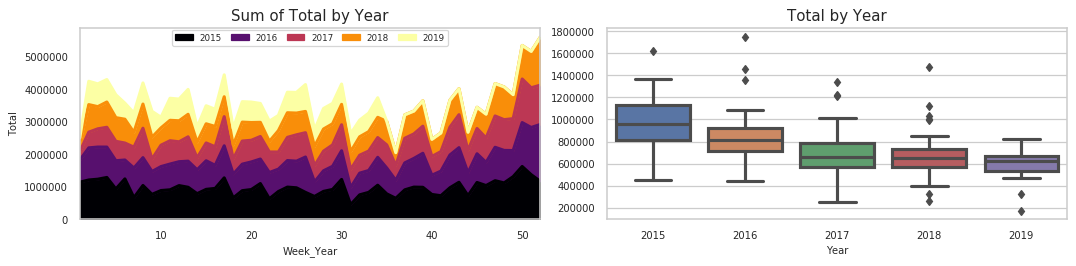

In [0]:
data = plot_var(df=df, y_axis='Total', stack='Year', x_axis1='Week_Year', x_axis2='Year', agg='Sum')

> Considerando essa mesma **análise individual por canal**, não houve nada muito diferente do padrão observado acima, a se destacar apenas que o volume de vendas para "SM" nesse período se manteve estável, contrariando a tendência de queda dos outros canais. 



---



---



**Graf.1 (esquerda):** O volume de vendas indiretas possui uma tendência de **alta** muito forte próxima ao **fim do mês**, o que é totalmente aceitável, visto que esse canal representa **revendedoras** e distribuidoras. Essa tendência também pode ser vista de forma mais suave no canal SM.


**Graf.2 (direita):** Podemos ver que o volume de **vendas mensal** é bastante **estável** no decorrer do ano, observando-se apenas um **aumento** expressivo para os **2 últimos meses do ano**, tendência que se repete em todos os canais.

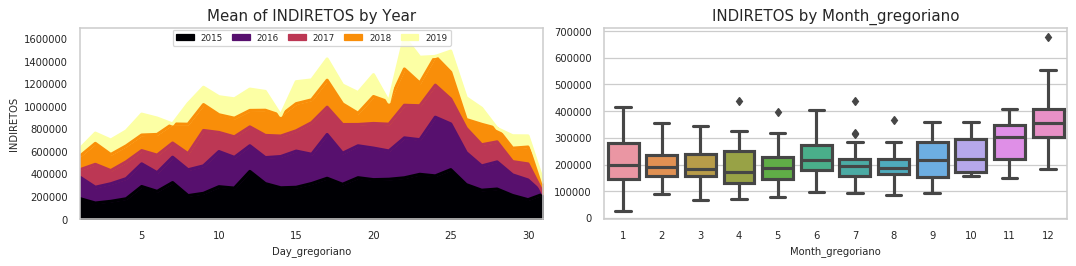

In [0]:
data = plot_var(df=df, y_axis='INDIRETOS', stack = 'Year', x_axis1='Day_gregoriano', x_axis2='Month_gregoriano', agg='Mean')



---



---



**Graf. 1 (esquerda):** Com esses dois gráficos usando a coluna **Next_holiday** no eixo das abcissas, podemos observar que há um **leve aumento** de vendas em **Supermercados**, em semanas próximas a feriados, indicando uma possível **antecipação** desses agentes.

**Graf.2 (direita):** O boxplot nos permite ver a mesma tendência do gráfico anterior, contudo podemos ver que para as colunas 0, 1 e 2 há uma grande presença de **outliers**.

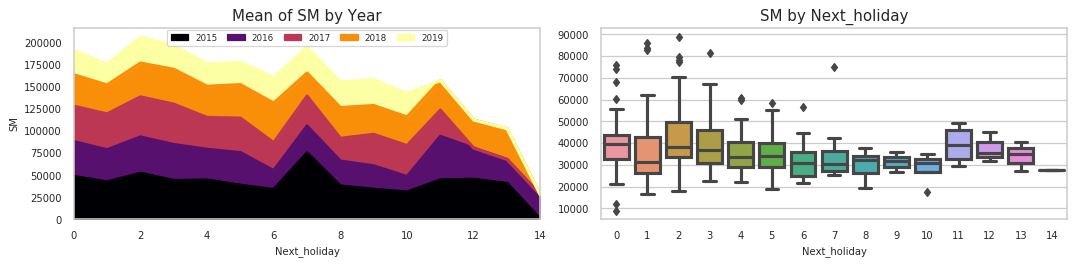

In [0]:
data = plot_var(df=df, y_axis='SM', stack = 'Year', x_axis1='Next_holiday', x_axis2='Next_holiday', agg='Mean')



---



---



## Checando Estacionariedade

> Vamos analisar as **séries de cada canal** de venda individualmente a vim de checar se são **estacionárias** e/ou **precisarão** de algum tipo de **transformação** antes de serem usadas **para treinar** os modelos

In [0]:
canais = df[['SM','ROUTE','INDIRETOS','OUTROS']].copy()

O gráfico abaixo mostra o **volume de vendas por canal**, com um **corte anual**, confirma o que foi visto na seção anterior, onde vemos pequenos picos de **sazonalidade** praticamente **mensal**, e um pico maior ao **fim de cada ano**, além de uma leve **tendência de queda**. O canal **"SM" **é o que representa um **nível** de vendas mais **baixo** comparado aos outros.

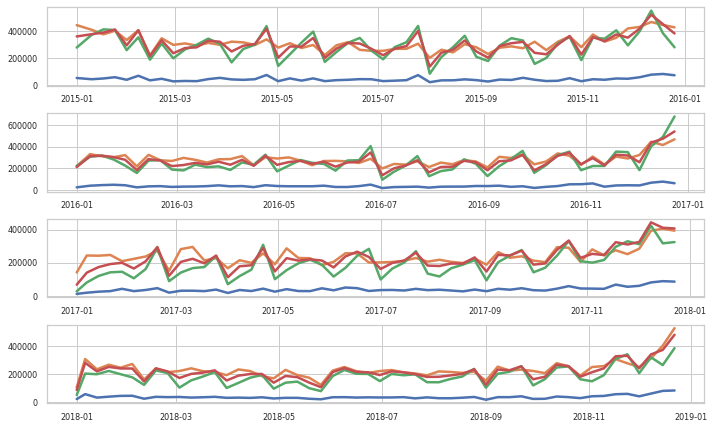

In [0]:
from stats import seasonal_plot
data = seasonal_plot(df=canais, ini='2015', fim='2018', frq='A')



---



---



> A **presença de sazonalidade** no gráfico anterior nos levou a fazer o teste **Adfuller**, a fim de uma checagem rápida para confirmar a presença de séries não estacionárias. O teste **rejeitou a hipótese nula**, ou seja a série é **não estacionária** (p-value >=.05) para o canal **"INDIRETOS"**, e chegou bem próximo desse valor para o canal **"ROUTE"**, isso indica que teremos de fazer algumas transformações nessas séries antes de treinar nosso modelo.

In [0]:
from stats import adf_test
adf_test(canais)

,Test Statistic,p-value,#Lags Used,Nº Obs.,Critical Val.(1%),Critical Val.(5%),Critical Val.(10%)
SM,-3.57,0.01,15.00,226.00,-3.46,-2.87,-2.57
ROUTE,-2.98,0.04,15.00,226.00,-3.46,-2.87,-2.57
INDIRETOS,-2.79,0.06,13.00,228.00,-3.46,-2.87,-2.57
OUTROS,-3.19,0.02,15.00,226.00,-3.46,-2.87,-2.57


> A respeito do Canal **"INDIRETOS"**, vemos que o **histórico** de vendas **não** possui uma distribuição **gaussiana**, já que há uma cauda longa a direita, além disso a **média** e o **desvio padrao anual** **não são estacionários**. Analisaremos essas variáveis novamente após algumas transformações, assim como também analisaremos a distribuições dos resíduos.

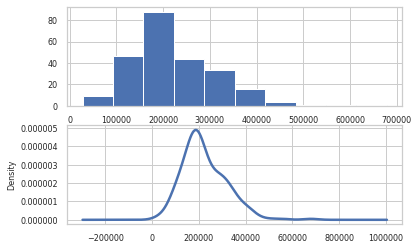

Datetime,2015,2016,2017,2018,2019
mean,"296,121.56","256,565.83","194,430.88","187,335.29","161,145.16"
std,"90,907.33","97,889.27","82,670.75","65,667.75","48,043.01"


time: 605 ms


In [0]:
pyplot.figure(1)
pyplot.subplot(211)
canais['INDIRETOS'].hist()
pyplot.subplot(212)
canais['INDIRETOS'].plot(kind='kde')
pyplot.show()
canais.groupby(canais.index.year)['INDIRETOS'].agg(['mean', 'std']).T



---



---



# Quick Setup

In [1]:
#ALL TOGETHER
def pip():
  !pip install pendulum
  !pip install ipython-autotime
  !git clone https://github.com/nicholasrichers/Desafio-Cola-Cola-Sofazao.git
  

def load_library(NAME_LIB, FILE_PATH):
    from importlib.machinery import SourceFileLoader
    FILE_PATH = '/content/Desafio-Cola-Cola-Sofazao/Datathon_Peta/' + FILE_PATH
    somemodule = SourceFileLoader(NAME_LIB, FILE_PATH).load_module()
    
    
def get_libs():
    #folder libraries
    load_library('adjust_datetime', 'libraries/adjust_datetime.py')
    load_library('adjust_datatype', 'libraries/adjust_datatype.py')
    load_library('plot_libraries', 'libraries/plot_libraries.py')
    load_library('holidays', 'libraries/holidays.py')
    load_library('stats', 'libraries/stats.py')
    
    #folder routines
    load_library('pre_processing_vendas', 'routines/pre_processing_vendas.py')
    load_library('pre_processing_macro', 'routines/pre_processing_macro.py')
    load_library('merge_datasets', 'routines/merge_datasets.py')
    load_library('pre_processing', 'routines/pre_processing.py')

    #folder models
    load_library('baseline_model', 'models/baseline_model.py')
    load_library('multi_baseline_model', 'models/multi_baseline_model.py')
    load_library('class_transform_dataset', 'models/class_transform_dataset.py')


def get_df():
  REPO_URL = 'https://raw.githubusercontent.com/nicholasrichers/Desafio-Cola-Cola-Sofazao/master/Datathon_Peta/datasets/'
  df = pd.read_csv(REPO_URL + 'trainDF.csv', sep=',', infer_datetime_format=True, parse_dates=['Datetime'], index_col=['Datetime'])
  #print(f'DF Shape: {df.shape}')
  return df 
    
def setup():
    pip()
    get_libs()
    df = get_df()
    print("===========================================")
    print("===========SETUP COMPLETE==================")
    print("===========================================")
    return df


#------------------------
import os, random, re, sys, time, warnings
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot
import seaborn as sns
from itertools import combinations
from scipy.stats import pearsonr
#------------------------
import statsmodels
print('statsmodels: %s' % statsmodels.__version__)
if(statsmodels.__version__ != '0.11.0'):
  !pip install statsmodels==0.11.0
  os.kill(os.getpid(), 9)
#----------------------
X = setup()
#---------------------
from plot_libraries import setup_graphics
setup_graphics()
#--------------------
pd.set_option('display.max_rows', 250)
pd.options.display.float_format = '{:,.2f}'.format
%matplotlib inline
%load_ext autotime

statsmodels: 0.11.0
     |████████████████████████████████| 143kB 4.2MB/s 
     |████████████████████████████████| 491kB 7.9MB/s 
  Created wheel for ipython-autotime: filename=ipython_autotime-0.1-cp36-none-any.whl size=1832 sha256=dae95523756c8744fcb34d4fc2fe69a174f4a31bca6a45248ffa07a3eecf6853
  Stored in directory: /root/.cache/pip/wheels/d2/df/81/2db1e54bc91002cec40334629bc39cfa86dff540b304ebcd6e
Successfully built ipython-autotime
Cloning into 'Desafio-Cola-Cola-Sofazao'...
remote: Enumerating objects: 198, done.
remote: Counting objects: 100% (198/198), done.
remote: Compressing objects: 100% (138/138), done.
remote: Total 198 (delta 101), reused 151 (delta 59), pack-reused 0
Receiving objects: 100% (198/198), 226.95 KiB | 1.75 MiB/s, done.
Resolving deltas: 100% (101/101), done.
===========SETUP COMPLETE==================


# Definindo o problema

## Tipos de Modelos


> Podemos definir esse problema como uma série temporal multivariada (múltiplas entradas), onde iremos fazer previsões de 2 tipos.

1. Para o "Total" de vendas (Multiple Input Multi-step Output)
2. Para os 4 "Canais" de vendas em paraelo (Multiple Parallel Input and Multi-step Output)


> Considerando o horizonte de predição, o modelo retornará um valor para cada unidade de tempo referente dentro do horizonte (Multiple Output Strategy)
```
prediction(t+1), prediction(t+2) = model(obs(t), obs(t-1), ..., obs(t-n))
```
Seguindo o exemplo acima, com horizonte de 2 semanas, a saída modelo para o "Total" sera (1x2), e para "Canais" (4x2).








Optamos por usar um horizonte de predição de ** 13 semanas**. Esse valor corresponde a **1 trimestre no calendário 445**, e essa divisão ajudará na dimensão da matriz em modelos futuros. Dessa forma separamos os últimos 13 registros do dataset para **testes**, e os **restante** será usado para **treino e validação**.
```
X_train = df.iloc[:-13, :]
X_test = df.iloc[-13:, :]
```

Por fim, como solicitado, utilizaremos a** métrica MAPE**, como base de comparação entre os modelos

In [2]:
results = dict()

time: 1.35 ms




---



---



## Modelo Baseline

> O nosso primeiro modelo serve apenas para usarmos como **base de comparação** para outros modelos a frente.

*Série(Total):* Usamos um **lag**, da série para 1 semana, 1 trimeste e 1 ano de diferença. Percebemos que a diferença pra 1 ano teve resultado bem superior *(+-15%)*

weekly: [36.08] 16.8, 56.5, 16.0, 15.0, 25.4, 138.9, 25.1, 30.8, 25.2, 24.9, 33.3, 27.9, 33.2
quarterly: [32.50] 54.0, 64.6, 26.1, 28.3, 40.5, 74.3, 20.4, 19.2, 10.7, 20.2, 17.4, 13.6, 33.2
yearly: [15.68] 29.4, 33.0, 12.0, 10.1, 12.1, 19.7, 10.0, 6.3, 18.9, 11.5, 19.4, 10.1, 11.3


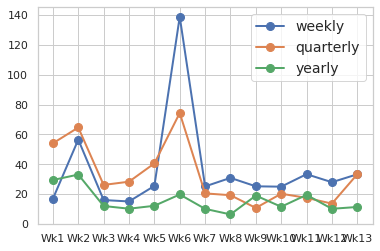

time: 332 ms


In [3]:
from baseline_model import baseline
results['baseline'] = baseline(X)



---



---



*Série(Canais):* Uma vez que já sabemos que o modelo *naive*, funciona melhor com diferença anual, vamos observar esse modelo discriminado **por canal** de vendas. Chegou a um resultado também próximo ao anterior

Yearly_SM: [30.24] 38.5, 57.7, 27.1, 16.8, 14.5, 56.8, 40.2, 7.9, 40.0, 22.6, 48.6, 11.8, 10.5
Yearly_ROUTE: [12.68] 23.0, 26.3, 11.8, 6.9, 11.7, 13.3, 6.1, 7.8, 12.6, 8.0, 13.9, 14.4, 9.2
Yearly_INDIRETOS: [20.52] 39.3, 37.7, 14.9, 13.5, 19.1, 25.8, 9.7, 8.9, 22.9, 15.8, 27.7, 11.9, 19.4
Yearly_OUTROS: [16.50] 30.6, 35.1, 11.0, 10.9, 9.7, 24.4, 12.6, 6.0, 20.8, 12.4, 21.1, 9.4, 10.5
Yearly_Canais(Mean): [16.50] 


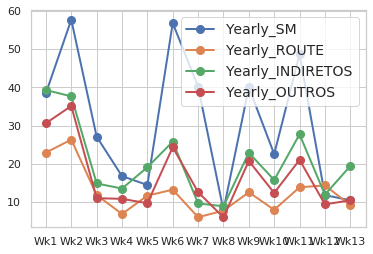

time: 323 ms


In [4]:
from multi_baseline_model import baseline_multi
results['baseline_multi'] = baseline_multi(X) 



---



---



## Feature Eng

Decompose

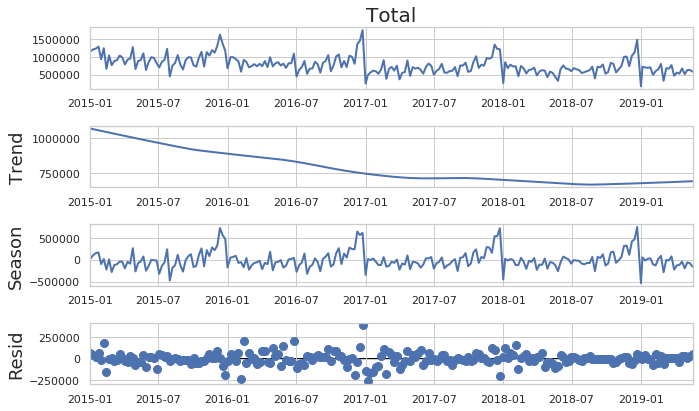

time: 1.87 s


In [5]:
from statsmodels.tsa.seasonal import STL
from pandas.plotting import register_matplotlib_converters
setup_graphics()
decompose = STL(X['Total'], period=52).fit()
decompose.plot()
pyplot.show()

In [13]:
from class_transform_dataset import Transform_Dataset

time: 1.2 ms


In [0]:
X.head(4)

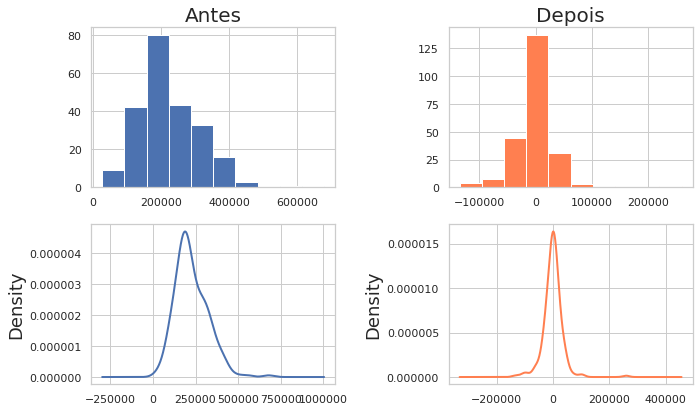

Datetime,2015,2016,2017,2018,2019
mean,"-3,772.74","9,303.93","-8,959.94",-643.90,"1,947.47"
std,"28,688.80","51,420.20","36,000.03","18,220.64","12,041.85"


time: 1.38 s


In [67]:



plot_residuos(X['INDIRETOS'], Xtm.df['INDIRETOS'])

In [43]:
Xtm = Transform_Dataset(get_df(), Multi=True)
Xtm.decompose()

time: 357 ms


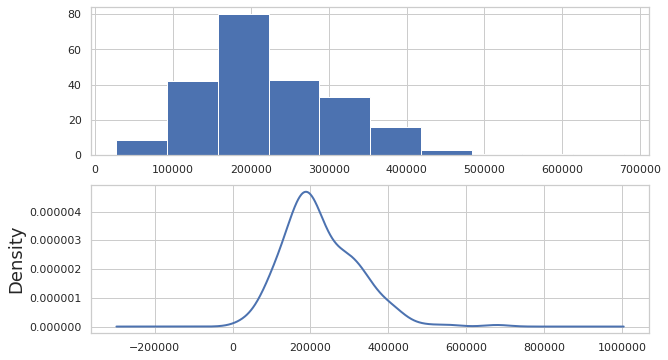

time: 798 ms


In [32]:
plot_residuos(X['INDIRETOS'], Xtm.df['INDIRETOS'])

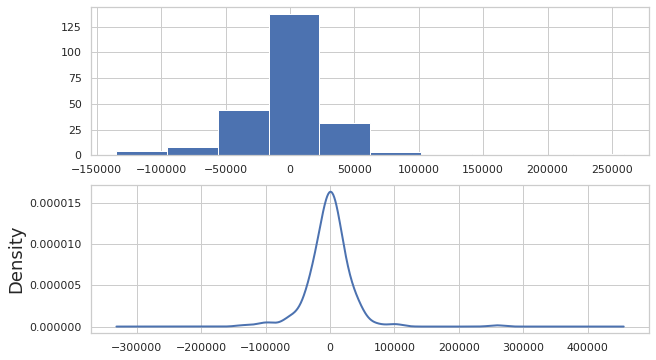

time: 703 ms


In [33]:
plot_residuos(Xt.df['INDIRETOS'])

time: 2.95 ms


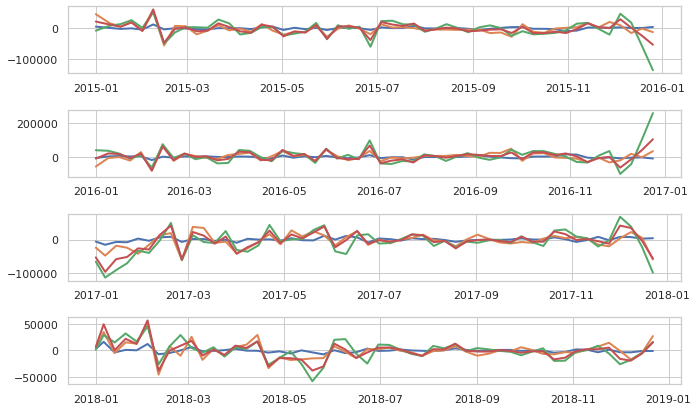

time: 1.4 s


In [40]:
from stats import seasonal_plot 
data = seasonal_plot(df=Xt.df.iloc[:, 1:5], ini='2015', fim='2018', frq='A')

In [0]:
Xt.df['INDIRETOS']

In [0]:
#testar estacionariedade
#from stats import adf_test
#adf_test(canais)

In [39]:
canais

,Total,SM,ROUTE,INDIRETOS,OUTROS,Day_gregoriano,Week_Month,Week_Year,Month_gregoriano,Year,holidays,Next_holiday,temperatura,Ajuste_ipca,PMC,Massa.Renda,Renda,Desemprego
Datetime,,,,,,,,,,,,,,,,,,
2015-01-10,"37,492.76","1,100.33","16,167.91","8,336.16","11,888.35",10,2,2,1,2015,0,6,27.54,256.57,97.99,"5,047,993.34","1,588.12",9.28
2015-01-17,"21,438.92","-2,040.19","5,166.17","13,367.87","4,945.08",17,3,3,1,2015,0,5,27.54,256.57,97.99,"5,047,993.34","1,588.12",9.28
2015-01-24,"64,397.79",-295.54,"20,071.61","26,024.81","18,596.90",24,4,4,1,2015,0,4,27.54,256.57,97.99,"5,047,993.34","1,588.12",9.28
2015-01-31,"-20,164.08","-4,413.43","-8,486.21","1,069.12","-8,333.55",31,5,5,1,2015,0,3,27.54,256.57,97.99,"5,047,993.34","1,588.12",9.28


time: 51 ms


In [0]:
#X =setup()
X = get_df()
#get_libs()
#X.head(1)

In [0]:
#se decomposicao nao der certo, power transform do target, box-cox transform (log1p) (MLM)

In [0]:

from scipy.stats import boxcox
from scipy.special import  inv_boxcox


#X.columns = ['Total']
X['TotalBC'], lam = boxcox(X['Total'])
print('Lambda: %f' % lam)

X['TotalBC_Inv'] = inv_boxcox(X['TotalBC'], lam)
pyplot.figure(1)
# line plot
pyplot.subplot(211)
pyplot.plot(X['TotalBC_Inv'])
# histogram
pyplot.subplot(212)
pyplot.plot(X['Total'])
#pyplot.hist(X['Total1'])
pyplot.show()

In [0]:
#testar estacionariedade
#from stats import adf_test
#adf_test(canais)
#residuo gaussiano?



---



---



## New Baseline

In [0]:
#testar os 2 tipos

Parte 2 (baseline+)
1. testar todas as transformacoes, nos 2 modelos
2. erro gaussiano?






---



---



# Guideline



---



---



Modelos TS/ML:
1. Seguir o guia das familias de modelos
2. Montar o Pipeline ML #MinMaxScaler or StandardScaler (scikit)
3. Montar o test harness dessa etapa (backtest)
4. RF (config mario), LGBM (+NN), XGB(shap) [fig(20,7)], 
5. feature selection(mario filho) (bom pra ver cols pra sair) 
2. testar os t, iterativamente Recursive Feature Selection (RFE).
5. rmsle, med por canal
6. Ver gráficos de avaliacao + scatter do erro (Vid5)
9. teste wilcox
7. ver se erro residual é gaussiano (gráfico mario filho)
8. Salvar e recuperar modelos para teste final
 

 Links:

 Buscar MLM BOston reg, para ML scikit

 https://stackoverflow.com/questions/56250306/how-to-fix-this-error-while-using-statsmodels-importerror-cannot-import-name (SARIMAX)

https://machinelearningmastery.com/feature-selection-time-series-forecasting-python/ (Feature selection com RFE)

https://machinelearningmastery.com/multi-step-time-series-forecasting-with-machine-learning-models-for-household-electricity-consumption/ (ver air pollution)

 https://machinelearningmastery.com/normalize-standardize-time-series-data-python/ (normalize)

 https://machinelearningmastery.com/make-predictions-time-series-forecasting-python/ (finalizar e salvar)

 https://machinelearningmastery.com/time-series-forecast-study-python-monthly-sales-french-champagne/ (champa, passa todos e salva)

https://machinelearningmastery.com/how-to-develop-a-skilful-time-series-forecasting-model/ (familia de modelos)

https://machinelearningmastery.com/how-to-develop-a-probabilistic-forecasting-model-to-predict-air-pollution-days/ (exemplo com ensembles)





---



---



DL e afins

https://www.youtube.com/watch?v=-7scQpJT7uo (activation func siraj)




---



---



# Guideline

Testes previos de estacionariedade (+ decompose):

1. fazer um lineplot dos canais(y), no tempo (x), e quebra por ano (onde tem esse plot? tem no 16 e champagne), 
2. checando estacionariedade: histograma do target (+density plot), med e std anual, boxplots e Ad fuller
3. Decomposicao [y(t) = Level + Trend + Seasonality + Noise], no livro tem um test harness completo disso (verificar quais q tem? ou fz o teste)
4. tirar sazonalidade polyfit() para tirar ambas, ordem 4 ou 5 ou fourier transform (+inverse transf)
5. Decidir quais colunas ficam (add no script)
6. Alinhar tudo com a EDA (test & train?)

Links:

https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/ (decomposicao graficos)

https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/?# (decompose)

https://machinelearningmastery.com/time-series-seasonality-with-python/ (polyfit)

https://machinelearningmastery.com/time-series-data-stationary-python/ (estacionariedade e AD fuller)

https://machinelearningmastery.com/time-series-forecast-study-python-monthly-sales-french-champagne/ (case champagne)



---



---




Baseline

1. criar base de teste de modelos (MLM) +  montar arquitetura (classes e baseline) (test & train)
2. Tamanho do histórico (sliding window) (ver se tem no harness do livro) 
3. test strategy (champa)
4. univ e multiv // multistep 10 semanas (MAPE e RMSLE) (recursivo, direto?)
5. 5 passos

Links: https://machinelearningmastery.com/simple-time-series-forecasting-models/ (ex test suite nao integrado)

https://machinelearningmastery.com/persistence-time-series-forecasting-with-python/(5 passos)

https://machinelearningmastery.com/multi-step-time-series-forecasting/ (tipos de multi-step, recursivo, direto)

Engenharia de features (testando sobre o baseline): (mario)
1. variaveis temporais Sem_Ano
2. diff(t1), MM(t4), diff_lag(1,2), sazonais, #(tirar sazonalidade polyfit() para tirar ambas, ordem 4 ou 5) ou fourier transform
3. Decomposicao [y(t) = Level + Trend + Seasonality + Noise], no livro tem um test harness completo disso (verificar quais q tem? ou fz o teste) (+inverse transf) (PROX?)
4. testar os t, iterativamente Recursive Feature Selection (RFE). (diz quais os melhores lags)
5. _dpreco p/ outras series c/ pivot (melt desfaz)
6. Expanding Window Statistics (entra no harness?)
7. power transform do target, box-cox transform (log1p) (MLM TS)
8. feature selection(mario filho) (bom pra ver cols pra sair) 
9. teste wilcox
10. Montar o Pipeline ML #MinMaxScaler or StandardScaler (scikit)
11. erro gaussiano?

Links:

https://machinelearningmastery.com/power-transform-time-series-forecast-data-python/ (box-cox)

https://machinelearningmastery.com/feature-selection-time-series-forecasting-python/ (RFE e random forest)

https://machinelearningmastery.com/basic-feature-engineering-time-series-data-python/ (expanding window)

 https://machinelearningmastery.com/time-series-forecast-study-python-monthly-sales-french-champagne/ (champa, passa todos e salva)





---



---



Modelos TS/ML:
1. Seguir o guia das familias de modelos
2. Montar o Pipeline ML #MinMaxScaler or StandardScaler (scikit)
3. Montar o test harness dessa etapa (backtest)
4. RF (config mario), LGBM (+NN), XGB(shap) [fig(20,7)], 
5. feature selection(mario filho) (bom pra ver cols pra sair) 
2. testar os t, iterativamente Recursive Feature Selection (RFE).
5. rmsle, med por canal
6. Ver gráficos de avaliacao + scatter do erro (Vid5)
9. teste wilcox
7. ver se erro residual é gaussiano (gráfico mario filho)
8. Salvar e recuperar modelos para teste final
 

 Links:

 Buscar MLM BOston reg, para ML scikit

https://machinelearningmastery.com/feature-selection-time-series-forecasting-python/ (Feature selection com RFE)

https://machinelearningmastery.com/multi-step-time-series-forecasting-with-machine-learning-models-for-household-electricity-consumption/ (ver air pollution)

 https://machinelearningmastery.com/normalize-standardize-time-series-data-python/ (normalize)

 https://machinelearningmastery.com/make-predictions-time-series-forecasting-python/ (finalizar e salvar)

 https://machinelearningmastery.com/time-series-forecast-study-python-monthly-sales-french-champagne/ (champa, passa todos e salva)

https://machinelearningmastery.com/how-to-develop-a-skilful-time-series-forecasting-model/ (familia de modelos)

https://machinelearningmastery.com/how-to-develop-a-probabilistic-forecasting-model-to-predict-air-pollution-days/ (exemplo com ensembles)





---



---



DL e afins

https://www.youtube.com/watch?v=-7scQpJT7uo (activation func siraj)




---



---

